# Exercise: ParmEst

In this exercise, you will practice using ParmEst to estimate four parameters ($U_a$, $U_b$, $C_p^H$, $C_p^S$) in the TCLab model using the step test data. We [previously estimated these parameters using the sine test data](../notebooks/parmest.ipynb).

In [1]:
import sys
# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"
else:
    import os

    if "exercise_solutions" in os.getcwd():
        # Add the "notebooks" folder to the path
        # This is needed for running the solutions from a separate folder
        # You only need this if you run locally
        sys.path.append('../notebooks')

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import TCLabExperiment, create_model, extract_results, extract_plot_results

## Load and explore experimental data (step test)

In [2]:
import pandas as pd
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.52,50.0,0.0
1,1.01,22.84,22.52,50.0,0.0
2,2.01,22.84,22.52,50.0,0.0
3,3.00,22.84,22.52,50.0,0.0
4,4.00,22.84,22.20,50.0,0.0


Make two plots to visualize the temperature and heat power data as a function of time.

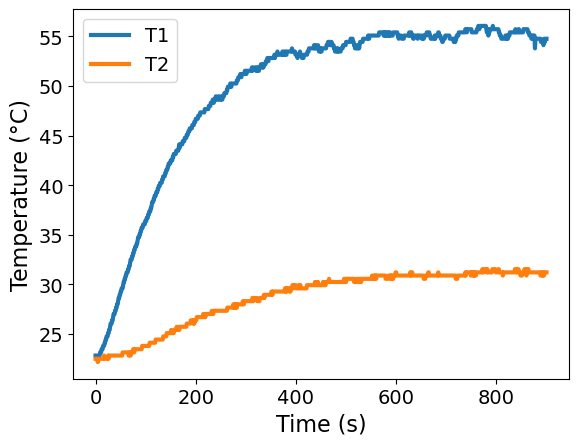

In [3]:
### BEGIN SOLUTION
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
### END SOLUTION

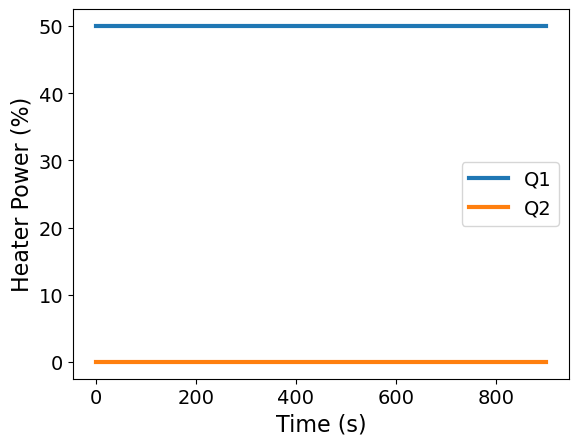

In [4]:
### BEGIN SOLUTION
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
### END SOLUTION

We'll now store the data in this custom *data class* objective. This is a nice trick to help keep data organized, but it is NOT required to use ParmEst or Pyomo data. Alternatively, we could just use a pandas DataFrame.

In [5]:
tc_data = TCLabExperiment(name="Sine Wave Test for Heater 1",
                            time=df['Time'].values,
                            T1=df['T1'].values,
                            u1=df['Q1'].values,
                            P1=200,
                            TS1_data=None,
                            T2=df['T2'].values,
                            u2=df['Q2'].values,
                            P2=200,
                            TS2_data=None,
                            Tamb=df['T1'].values[0])

Our custom data class has a method to export the data as a Pandas Data Frame.

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,22.84,50.0,200,None,22.52,0.0,200,None,22.84
1,1.01,22.84,50.0,200,None,22.52,0.0,200,None,22.84
2,2.01,22.84,50.0,200,None,22.52,0.0,200,None,22.84
3,3.00,22.84,50.0,200,None,22.52,0.0,200,None,22.84
4,4.00,22.84,50.0,200,None,22.20,0.0,200,None,22.84


## Parameter estimation with ParmEst

Now for the main event: performing nonlinear least squares with `ParmEst`.



(model_function, data, theta_names). This interface will be removed in a
future release, please update to the new parmest interface using experiment
lists.  (deprecated in 6.7.2) (called from
/Users/adowling/opt/anaconda3/envs/summer2024/lib/python3.10/functools.py:926)
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    15301
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8103

Total number of variables............................:     3606
     

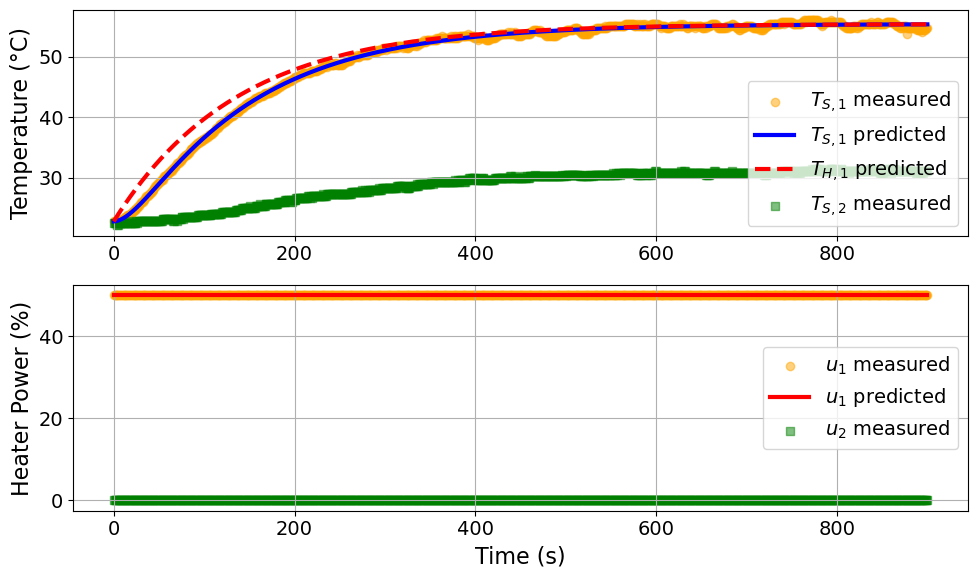

Model parameters:
Ua = 0.0491 Watts/degC
Ub = 0.0004 Watts/degC
CpH = 6.6745 Joules/degC
CpS = 0.01 Joules/degC
 


In [7]:
# Call ParmEst
### BEGIN SOLUTION
import pyomo.contrib.parmest.parmest as parmest

parmest_create_model = lambda data: create_model(data=data, 
                                                 mode='parmest',
                                                 number_of_states=2)

# define the parameter names as a list
# two-state model
theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']

# four-state model
#theta_names = ['Ua', 'Ub', 'Uc','inv_CpH', 'inv_CpS']

# Create a parameter estimation object
pest = parmest.Estimator(parmest_create_model,
                         data=[tc_data.to_data_frame()], # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
                         theta_names=theta_names,
                         tee=True)

obj, theta = pest.theta_est()

'''
obj, theta, cov = pest.theta_est(calc_cov=True, # boolean to calculate the covariance matrix
                                    cov_n = len(tc_data.time) # number of data points in the least squares objective
)
'''
### END SOLUTION

# Visualize the results using our custom function
### BEGIN SOLUTION
parmest_regression_results2 = extract_plot_results(tc_data, 
                                                   pest.pest_deprecated.parmest_model)
### END SOLUTION


### BEGIN SOLUTION
# Print the covariance matrix
# print("Covariance matrix:")
# print(cov)
### END SOLUTION

**Discussion**: How do these results compare to our [previous analysis](../notebooks/parmest.ipynb)?